# Product Stocking Analytics: iPhone vs. Google Products at Best Buy


![Sentiment Analysis](Customer-survey-feedback.jpg)

## **Overview**

Best Buy, a prominent reseller of iPhone and Google products, seeks to optimize its stocking decisions by understanding user sentiments towards these products. This data science project focuses on leveraging Twitter sentiment analysis to gain insights into customer opinions and preferences regarding iPhone and Google products. By analyzing user sentiments, Best Buy aims to make informed stocking decisions that align with customer demand and enhance overall customer satisfaction.
The project involves collecting Twitter data related to discussions, reviews, and mentions of iPhone and Google products, followed by preprocessing and sentiment analysis. The insights derived from this analysis will guide Best Buy in optimizing its product assortment and ensuring a strategic alignment with customer preferences.

## **Problem statement**

Best Buy, a leading reseller of iPhone and Google products, faces the challenge of stocking its inventory to match customer preferences. The absence of a systematic approach to analyze user sentiments on platforms like Twitter hinders data-driven stocking decisions. This project aims to leverage Twitter sentiment analysis to understand customer opinions better. By gaining insights into user sentiments, Best Buy seeks to improve stocking decisions, ensuring availability of products aligned with
customer preferences and enhancing overall satisfaction and loyalty

## **Business Value**

By leveraging Twitter sentiment analysis to understand customer opinions, Best Buy will be able to make more informed stocking decisions leading to better allocation of resources, improved product assortment, enhanced customer satisfaction and profitability. By staying ahead of trends and understanding customer sentiments better than competitors, Best Buy can position itself as a preferred destination for purchasing iPhone and Google products.

## **Objective**

The goal of this project is to analyse customer sentiments on Twitter to inform Best Buy's stocking decisions for iPhone and Google products. By analyzing customer opinions, the aim is to improve resource allocation, optimize product assortment, enhance customer satisfaction, and ultimately increase profitability.

## **Research Questions**

1. What are the primary sentiments expressed by customers on Twitter regarding iPhone and Google products?

2. What factors influence the polarity of tweets related to iPhone and Google products on Twitter?

3. Which specific features of iPhone and Google products are most frequently praised or criticized by users on Twitter?

4. Which machine learning model is most effective in sentiment analysis?


## **Data Understanding**

The dataset used in this project was obtained from CrowdFlower via https://data.world/crowdflower/brands-and-product-emotions where Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.



### Import libraries and load data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import re
from string import punctuation

#sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# nlkt
from nltk import FreqDist
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
# Define color map for plots
# Import color map
import matplotlib.cm as cm
# Choose a predefined colormap
colormap = cm.coolwarm  # Choose a diverging colormap like 'coolwarm', 'RdBu', 'seismic', etc.

# Create a color array with a range of colors from the chosen colormap
color_array = [colormap(i) for i in range(20)]  # Choose 20 colors from the palette

# Set the default color cycle to the color array
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_array)

In [3]:
# Load data and check structure 
data = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
8718,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
8719,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
# Checking data structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [5]:
# Check missing values
data.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5552
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
# Checking index of missing value in tweet column
data[data['tweet_text'].isna()].index

Index([6], dtype='int64')

In [7]:
# Dropping the row above
data.drop(index=data[data['tweet_text'].isna()].index, inplace= True)

In [8]:
# Change column names to shorten long column names
data.columns = ['tweet', 'brand_product', 'emotion']

In [9]:
# Change 'No emotion toward brand or product' to 'Neutral emotion'
data.loc[data['emotion'] == 'No emotion toward brand or product', 'emotion'] = 'Neutral emotion'

In [10]:
# Checking value counts for regarding column
data.brand_product.value_counts()

brand_product
iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: count, dtype: int64

In [11]:
# Derive 'brand_product' from tweets to fill missing values in former column
categories = np.array(['iPad', 'Apple', 'iPad', 'iPhone', 'Google', 'Android'])
for i, row in data.iterrows():
    if pd.isnull(row['brand_product']):
        for category in np.concatenate((categories, np.char.lower(categories))):
            if category in row['tweet']:
                # Use .loc[] to assign values to DataFrame
                data.loc[i, 'brand_product'] = category
                break  # Break out of inner loop once a category is found

In [12]:
# Check missing values, again
data.isna().sum()

tweet              0
brand_product    787
emotion            0
dtype: int64

In [13]:
# Percentage missing data for regarding column
787/len(data)

0.09025229357798165

In [14]:
# Drop rows with missing data
data.dropna(inplace= True)
data

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8716,Ipad everywhere. #SXSW {link},iPad,Positive emotion
8717,"Wave, buzz... RT @mention We interrupt your re...",google,Neutral emotion
8718,"Google's Zeiger, a physician never reported po...",Google,Neutral emotion
8719,Some Verizon iPhone customers complained their...,iPhone,Neutral emotion


In [15]:
# Check for duplicate entries
data.duplicated().sum()

20

In [16]:
#Remove duplicates
data.drop_duplicates(inplace=True)

emotion
Neutral emotion     4381
Positive emotion    2845
Negative emotion     543
I can't tell         144
Name: count, dtype: int64


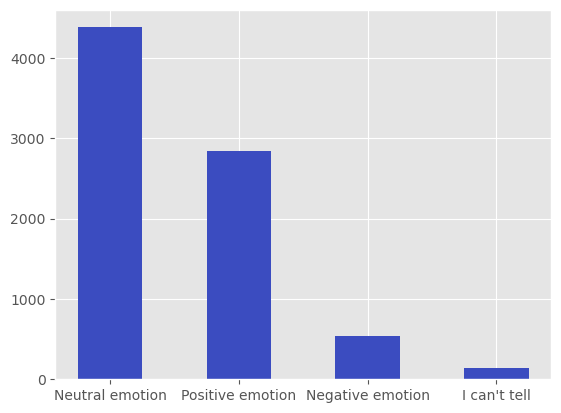

In [17]:
# Check classes for target feature
print(data.emotion.value_counts())
plt.bar(data.emotion.value_counts().index, data.emotion.value_counts(), width=.5);

In [18]:
# Drop rows where emotion is 'I can't tell'
data.drop(index=data[data['emotion'] == 'I can\'t tell'].index, inplace= True)
data.reset_index(drop=True, inplace=True)
data

,tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
7764,Ipad everywhere. #SXSW {link},iPad,Positive emotion
7765,"Wave, buzz... RT @mention We interrupt your re...",google,Neutral emotion
7766,"Google's Zeiger, a physician never reported po...",Google,Neutral emotion
7767,Some Verizon iPhone customers complained their...,iPhone,Neutral emotion


In [19]:
# View full text on sample tweets
data[['tweet']].sample(10).style.set_properties(**{'text-align': 'left'})

,tweet
5776,RT @mention Thank you to @mention for letting me test drive a car to the Apple store. Now lets hope that they can fix my phone!! #sxsw
2804,@mention Go beyond the hour & share positive actions with the world. Download the #EarthHour iPhone app: {link} #SXSW
7123,damm smart.. RT @mention RT @mention Apple is opening up a temp store in Austin for #SXSW {link} via @mention #iPad2
7495,If you haven't waited in line for an Apple product you're missing out on an important rite of passage. #sxsw
1459,@mention #SXSW don't forget @mention to plan your schedule. Plus our free iphone app {link}
5730,"RT @mention Slides from #SXSW talk, ""iPad Design Headaches "" {link} #tapworthy . Really interesting for designers as well."
2086,Your brand focus? RT @mention 'Trust of Zappos + Likability of Virgin + Product of Apple' - recipe for success @mention #SXSW
4632,"RT @mention Apparently, if you Google ""ad preferences"" and you'll see what Google thinks you'll like. #seenocreepy #sxsw"
1152,Make sure you bring your business card to the #nonprofit meetup at #sxsw. It's your ticket into our drawing for a $100 Apple gift card.
1899,Marissa Mayer: 40% Of Google Maps Usage Is Mobile (And There Are 150 Million Mobile Users) {link} #google #SXSW #TC


In [20]:
# Function to remove tweet handles(words that start with @), HTML tags and URLs in tweets
def remove_html_urls_mentions(input_text):
    # Remove HTML tags
    pattern_html = re.compile('<.*?>')
    text_without_html = pattern_html.sub(r'', input_text)
    
    # Remove URLs
    text_without_urls = re.sub(r"http\S+|www\S+|https\S+", "", text_without_html)
    
    # Remove #, ?, ., {link}, (, ), and standalone numbers
    text_without_nums = re.sub(r'[#?.{}()\/\\]|{link}|\b\d+\b', '', text_without_urls)
    
    # Remove Twitter usernames (mentions)
    text_without_mentions = re.sub(r'@\w+\s*', '', text_without_nums)
    
    return text_without_mentions

In [21]:
# Function to encode emojis
def encode_emojis(text):
    """
    Encode emojis in text using Unicode.

    Parameters:
    text (str): Input text containing emojis.

    Returns:
    str: Text with emojis encoded using Unicode.
    """
    # Encode emojis using Unicode escape sequences
    emoji_encoded_text = text.encode('unicode-escape').decode('utf-8')
    
    return emoji_encoded_text

In [22]:
# Remove tweet handles(words that start with @), HTML tags and URLs in tweets, and encode emojis
data['cleaned_tweet'] = data['tweet'].apply(lambda text: encode_emojis(remove_html_urls_mentions(text)))
data = data[['tweet', 'cleaned_tweet', 'brand_product', 'emotion']].copy()
data

,tweet,cleaned_tweet,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,I have a 3G iPhone After hrs tweeting at RISE...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Know about Awesome iPadiPhone app that you'll ...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Can not wait for iPad also They should sale t...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,I hope this year's festival isn't as crashy as...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"great stuff on Fri SXSW: Marissa Mayer Google,...",Google,Positive emotion
...,...,...,...,...
7764,Ipad everywhere. #SXSW {link},Ipad everywhere SXSW link,iPad,Positive emotion
7765,"Wave, buzz... RT @mention We interrupt your re...","Wave, buzz RT We interrupt your regularly sche...",google,Neutral emotion
7766,"Google's Zeiger, a physician never reported po...","Google's Zeiger, a physician never reported po...",Google,Neutral emotion
7767,Some Verizon iPhone customers complained their...,Some Verizon iPhone customers complained their...,iPhone,Neutral emotion


In [23]:
# drop index 7788 with encoding issues
data.drop(index=7768, inplace= True)

## Exploratory Data Analysis

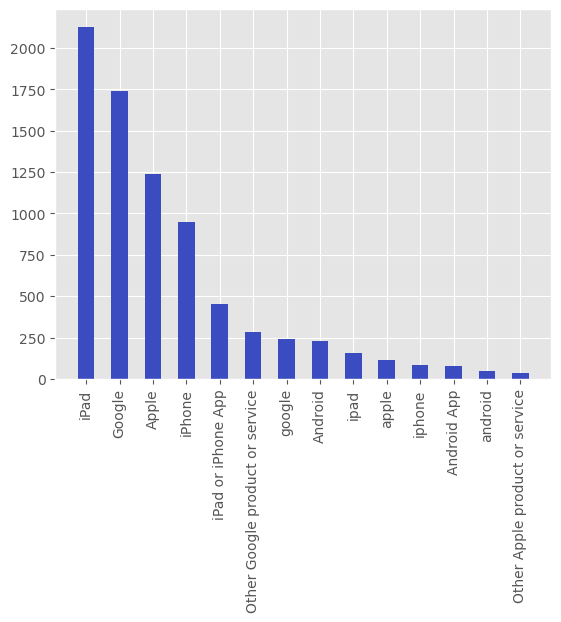

In [24]:
# EDA
data['brand_product'].value_counts()
plt.bar(data['brand_product'].value_counts().index, data['brand_product'].value_counts(), width=.5)
plt.xticks(rotation=90);

In [25]:
# Merge regarding into only two categories: apple and google brands
Apple = ['iPad', 'Apple', 'iPhone', 'iPad or iPhone App', 'ipad', 'apple', 'iphone', 'Other Apple product or service']
Google = ['Google', 'google', 'Other Google product or service', 'Android', 'Android App', 'android']

for index, row in data.iterrows():
    if row['brand_product'] in Apple:
        data.at[index, 'brand_product'] = 'Apple'
    elif row['brand_product'] in Google:
        data.at[index, 'brand_product'] = 'Google'

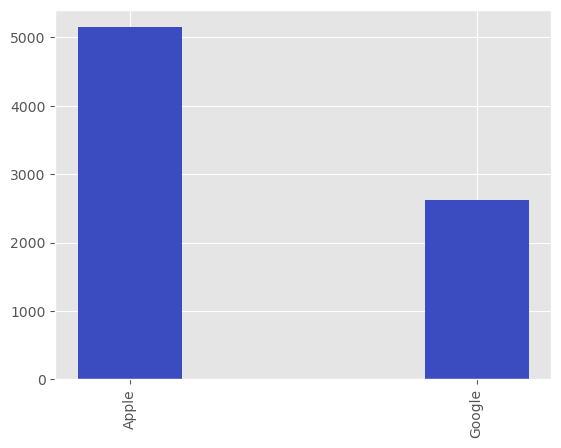

In [26]:
# Re-check regarding column
data['brand_product'].value_counts()
plt.bar(data['brand_product'].value_counts().index, data['brand_product'].value_counts(), width=.3)
plt.xticks(rotation=90);

In [27]:
# Function to tokenize and remove stopwords and punctuation
def process_tweet(tweet):
    tweet = tweet.lower() #convert tweet to lowercase
    # Define a regular expression pattern to match words including apostrophes
    pattern = r"\b\w+(?:'\w+)?\b"
    # Create a RegexpTokenizer with the defined pattern
    tokenizer = RegexpTokenizer(pattern)
    # Tokenize tweet
    tokens = tokenizer.tokenize(tweet)
    tokens = [token for token in tokens if token not in stopwords.words('english') 
              and token not in punctuation]                                        #remove stopwords and punctuations
    return tokens

# Apply function
data['tokenized_tweets'] = data['cleaned_tweet'].apply(process_tweet)

In [28]:
# Change columns arrangement
data = data[['tweet', 'cleaned_tweet', 'tokenized_tweets', 'brand_product', 'emotion']]
data

,tweet,cleaned_tweet,tokenized_tweets,brand_product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,I have a 3G iPhone After hrs tweeting at RISE...,"[3g, iphone, hrs, tweeting, rise_austin, dead,...",Apple,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Know about Awesome iPadiPhone app that you'll ...,"[know, awesome, ipadiphone, app, likely, appre...",Apple,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Can not wait for iPad also They should sale t...,"[wait, ipad, also, sale, sxsw]",Apple,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,I hope this year's festival isn't as crashy as...,"[hope, year's, festival, crashy, year's, iphon...",Apple,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,"great stuff on Fri SXSW: Marissa Mayer Google,...","[great, stuff, fri, sxsw, marissa, mayer, goog...",Google,Positive emotion
...,...,...,...,...,...
7763,"@mention Yup, but I don't have a third app yet...","Yup, but I don't have a third app yet I'm on A...","[yup, third, app, yet, i'm, android, suggestio...",Google,Neutral emotion
7764,Ipad everywhere. #SXSW {link},Ipad everywhere SXSW link,"[ipad, everywhere, sxsw, link]",Apple,Positive emotion
7765,"Wave, buzz... RT @mention We interrupt your re...","Wave, buzz RT We interrupt your regularly sche...","[wave, buzz, rt, interrupt, regularly, schedul...",Google,Neutral emotion
7766,"Google's Zeiger, a physician never reported po...","Google's Zeiger, a physician never reported po...","[google's, zeiger, physician, never, reported,...",Google,Neutral emotion


In [29]:
# Generate Frequency distirbution
FreqDist(data['tokenized_tweets'].explode())

FreqDist({'sxsw': 8175, 'link': 3303, 'rt': 2571, 'ipad': 2308, 'google': 2219, 'apple': 2044, 'quot': 1473, 'iphone': 1437, 'store': 1370, 'new': 1000, ...})

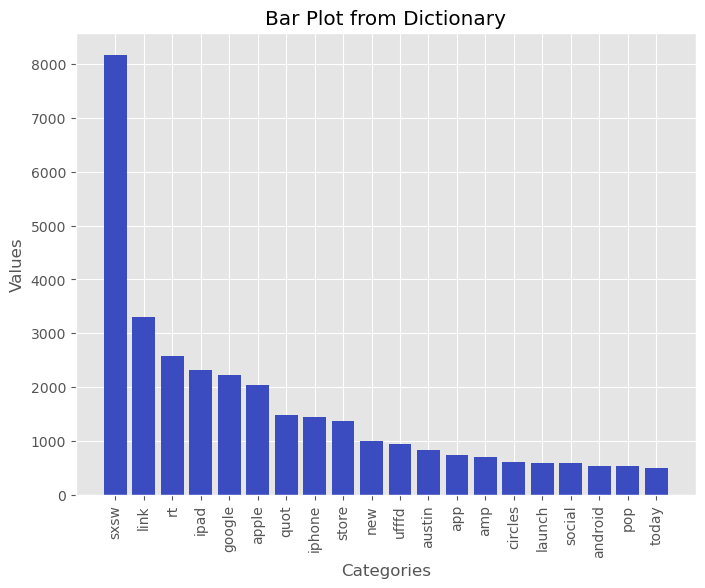

In [30]:
# Extract top 20 tokens and their values 
top_20 = FreqDist(data['tokenized_tweets'].explode()).most_common(20)
categories, values = zip(*top_20)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, values)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot from Dictionary')
plt.xticks(rotation=90)
plt.show()

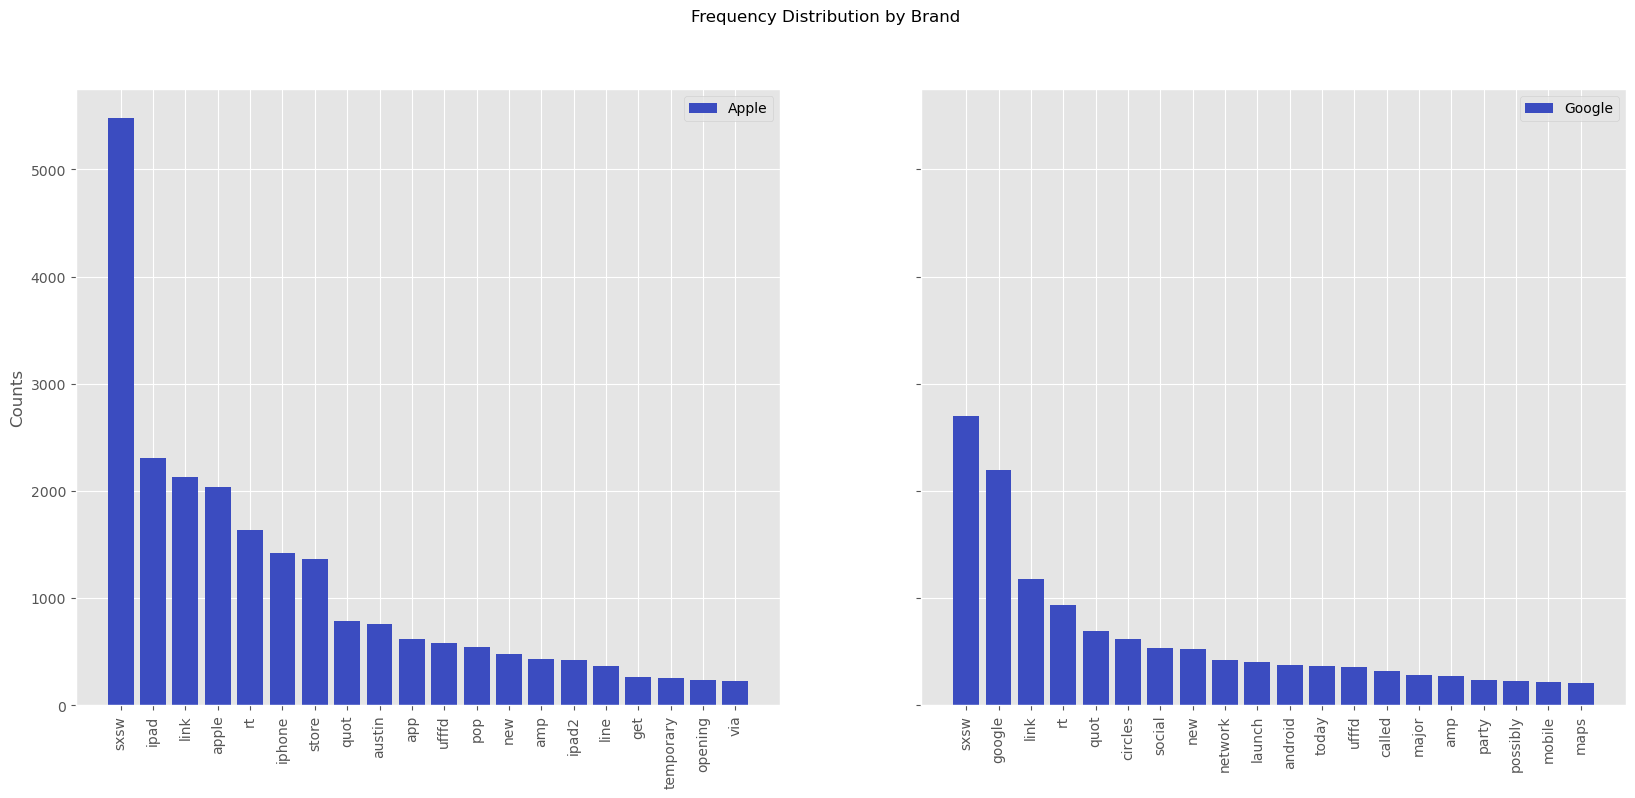

In [31]:
#check distribution by regarding category
apple = data[data['brand_product'] == 'Apple']
google = data[data['brand_product'] == 'Google']

# Extract top 20 tokens and their values for apple brand
apple_top_20 = FreqDist(apple['tokenized_tweets'].explode()).most_common(20)
apple_categories, apple_values = zip(*apple_top_20)

# Extract top 20 tokens and their values for google brand
google_top_20 = FreqDist(google['tokenized_tweets'].explode()).most_common(20)
google_categories, google_values = zip(*google_top_20)

# Create a bar plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True) 
axes[0].bar(apple_categories, apple_values, label='Apple')
axes[1].bar(google_categories, google_values, label='Google')
axes[0].set_ylabel('Counts')
fig.suptitle('Frequency Distribution by Brand')
axes[0].set_xticklabels(apple_categories, rotation=90) 
axes[1].set_xticklabels(google_categories, rotation=90)
# Set legends on the axes
axes[0].legend()
axes[1].legend()

plt.show()

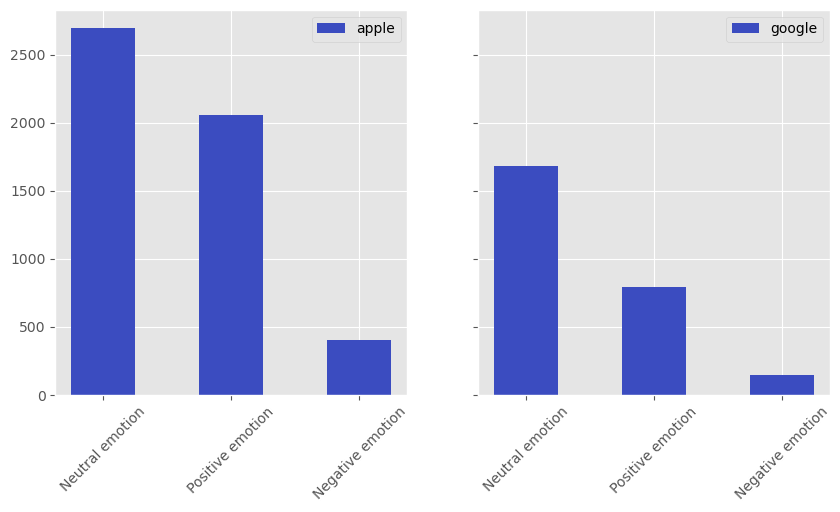

In [32]:
# Sentiments by brand
fig, ax = plt.subplots(nrows=1, ncols= 2, figsize= (10, 5), sharey= True)
ax[0].bar(apple['emotion'].value_counts().index, apple['emotion'].value_counts(), width= .5, label='apple');
ax[1].bar(google['emotion'].value_counts().index, google['emotion'].value_counts(), width= .5, label= 'google')
ax[0].legend()
ax[1].legend()

for axis in ax:
    axis.tick_params(axis='x', rotation=45)
    
plt.show()

In [33]:
# Check token distribution based on emotion
positive_emotions_data = data[data['emotion'] == 'Positive emotion']
negative_emotions_data = data[data['emotion'] == 'Negative emotion']

# Extract top 20 tokens and their values for apple brand
positive_top_20 = FreqDist(positive_emotions_data['tokenized_tweets'].explode()).most_common(20)
positive_categories, positive_values = zip(*positive_top_20)

# Extract top 20 tokens and their values for google brand
negative_top_20 = FreqDist(negative_emotions_data['tokenized_tweets'].explode()).most_common(20)
negative_categories, negative_values = zip(*negative_top_20)

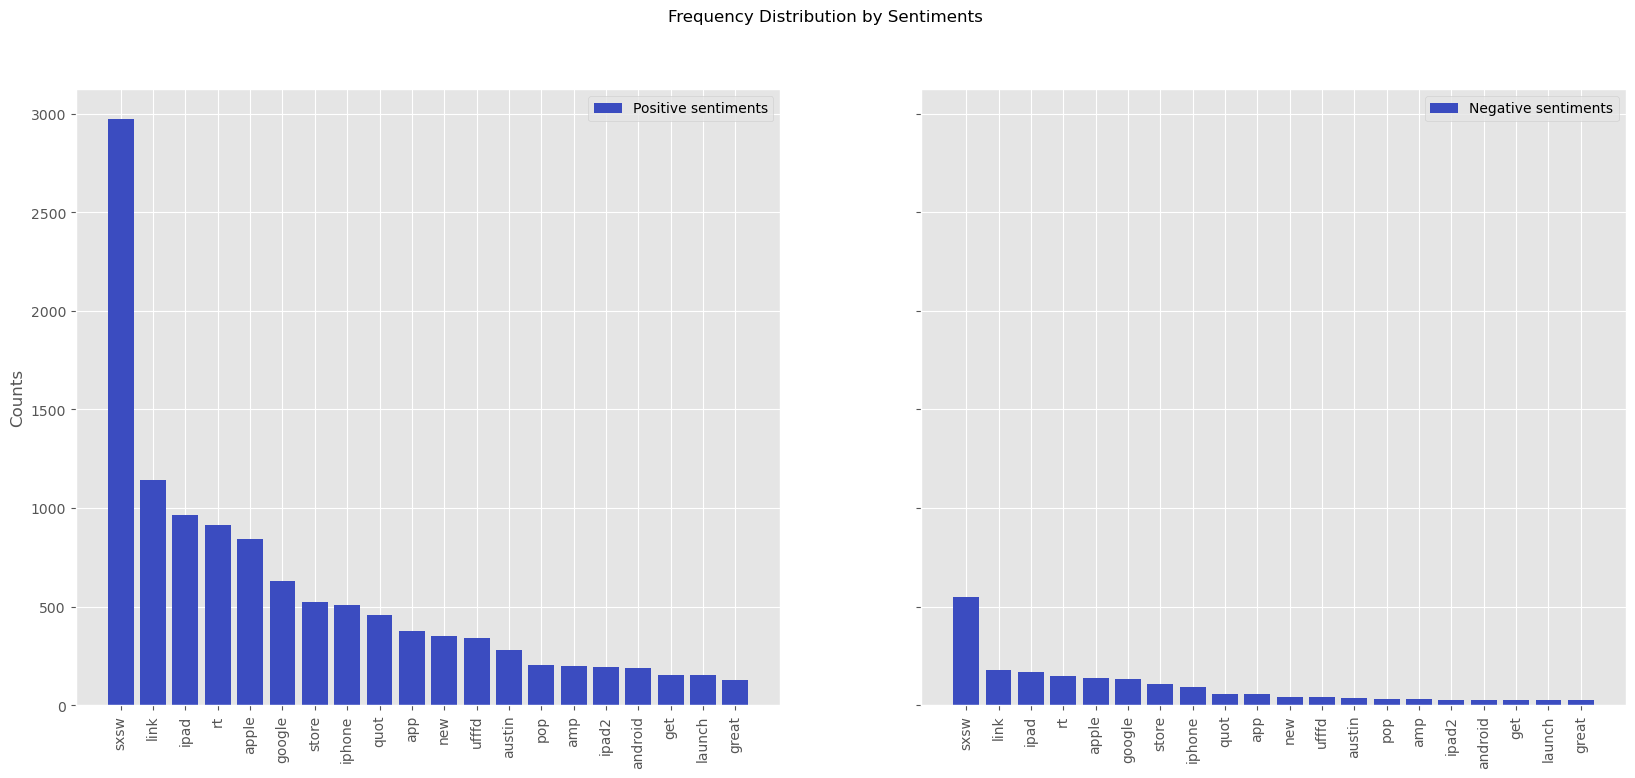

In [34]:
# Create a bar plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True) 
axes[0].bar(positive_categories, positive_values, label='Positive sentiments')
axes[1].bar(negative_categories, negative_values, label='Negative sentiments')
axes[0].set_ylabel('Counts')
fig.suptitle('Frequency Distribution by Sentiments')
axes[0].set_xticklabels(positive_categories, rotation=90) 
axes[1].set_xticklabels(positive_categories, rotation=90)
# Set legends on the axes
axes[0].legend()
axes[1].legend()

plt.show()

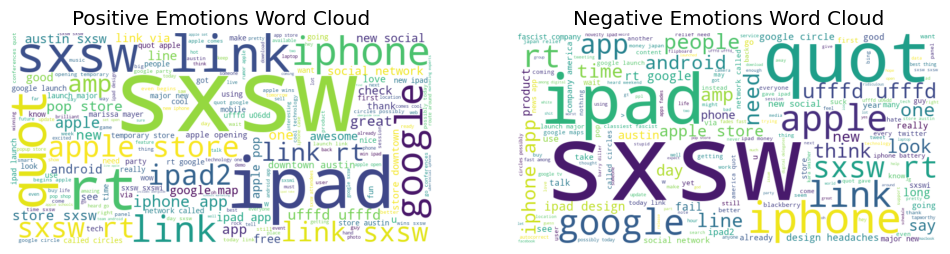

In [35]:
# Combine tokenized tweets into text strings
positive_text = ' '.join(positive_emotions_data['tokenized_tweets'].explode())
negative_text = ' '.join(negative_emotions_data['tokenized_tweets'].explode())

# Create word clouds for positive and negative emotions
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot word clouds
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Emotions Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Emotions Word Cloud')
plt.axis('off')

plt.show()

## **Vectorization**

TF-IDF technique will be used to convert the text data into numerical representations that the ML algorithm can process.

In [36]:
# Using TF-IDF and max_features at 1000
from sklearn.feature_extraction.text import TfidfVectorizer
cleaned_tweet = data['cleaned_tweet']

tfidf_vectorizer = TfidfVectorizer(max_features=1000) 

X_tfidf = tfidf_vectorizer.fit_transform(cleaned_tweet)

## **Smote**

SMOTE is a data resampling technique used to address class imbalance by generating synthetic samples for the minority class.In this case our minority is negative emotion.

In [37]:
#apply SMOTE to address class imbalance

# DataFrame 'data' with columns 'cleaned_tweets' and 'emotion'
X = data['cleaned_tweet']
y = data['emotion']

#Instantiate Tfidf Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Vectorize text data using TF-IDF; max_features at 1000
vectorizer = TfidfVectorizer(max_features=1000)  

# Fit and transform text data
X_tfidf = vectorizer.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

## **Models**

### Naive Bayes classifer

In [38]:
#Split the Data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Naive Bayes classifer 
clf1_NB = MultinomialNB()
clf1_NB.fit(X_train, y_train)



MultinomialNB()

In [39]:
def get_prediction(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('Training Prediction')
    print('--------------------')
    print(classification_report(y_train, y_train_pred))
    print('Test Prediction')
    print('--------------------')
    print(classification_report(y_test, y_test_pred))
    
    return y_train_pred, y_test_pred

In [40]:
_, _ = get_prediction(clf1_NB, X_train, X_test, y_train, y_test)

Training Prediction
--------------------
                  precision    recall  f1-score   support

Negative emotion       0.86      0.06      0.11       433
 Neutral emotion       0.69      0.90      0.78      3481
Positive emotion       0.73      0.50      0.59      2300

        accuracy                           0.70      6214
       macro avg       0.76      0.49      0.49      6214
    weighted avg       0.71      0.70      0.66      6214

Test Prediction
--------------------
                  precision    recall  f1-score   support

Negative emotion       0.75      0.03      0.05       110
 Neutral emotion       0.67      0.86      0.75       899
Positive emotion       0.61      0.43      0.50       545

        accuracy                           0.65      1554
       macro avg       0.68      0.44      0.44      1554
    weighted avg       0.65      0.65      0.62      1554



The model performs reasonably well on the "neutral" emotion but struggles more with the "negative" and "positive" classes, especially in terms of precision and recall. This imbalance in performance might indicate a class imbalance issue or that the model needs further optimization to better distinguish between the different sentiment classes.

### Random Forest

In [41]:
# Initialize Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=6)

# Train the classifier
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1000, n_jobs=6, random_state=0)

In [42]:
# Evaluate the model
_, _ = get_prediction(rf_classifier, X_train, X_test, y_train, y_test)

Training Prediction
--------------------
                  precision    recall  f1-score   support

Negative emotion       1.00      0.99      0.99       433
 Neutral emotion       0.99      1.00      0.99      3481
Positive emotion       1.00      0.98      0.99      2300

        accuracy                           0.99      6214
       macro avg       0.99      0.99      0.99      6214
    weighted avg       0.99      0.99      0.99      6214

Test Prediction
--------------------
                  precision    recall  f1-score   support

Negative emotion       0.63      0.20      0.30       110
 Neutral emotion       0.70      0.86      0.77       899
Positive emotion       0.67      0.50      0.58       545

        accuracy                           0.69      1554
       macro avg       0.67      0.52      0.55      1554
    weighted avg       0.68      0.69      0.67      1554



The Random Forest model shows impressive performance on the training data with high precision, recall, and F1-score for all classes. However, on the test data, the model's performance is slightly lower but still respectable, with an accuracy of 69%. Overall, the Random Forest model shows strong performance on both training and test data, demonstrating its effectiveness for sentiment analysis tasks. An accuracy of 69% is a good baseline for any text classification. 

### Decision Tree

In [43]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Train Decision Tree Model
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Evaluate Model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


                  precision    recall  f1-score   support

Negative emotion       0.29      0.25      0.27       110
 Neutral emotion       0.70      0.70      0.70       899
Positive emotion       0.52      0.54      0.53       545

        accuracy                           0.61      1554
       macro avg       0.51      0.50      0.50      1554
    weighted avg       0.61      0.61      0.61      1554



## Findings 


Based on the analysis of customer sentiment on Twitter, it was found that Google and Apple brands had the highest number of customers expressing a neutral emotion, followed by a positive emotion. Negative sentiments were least common for both brands.

It was observed that the SXSW event had a significant influence on customer sentiment and received the highest number of mentions. The release of new products by Apple and Google coincided with an increase in positive sentiment expressed on Twitter.

The sentiment analysis of tweets revealed a notable amount of negativity towards the design of the iPad device. The Apple Store stood out as a feature that garnered notable positivity among users. Apple's iPhone and iPad devices received the highest positive sentiment among consumers, reinforcing their esteemed reputation within the Apple brand lineup. Among Google products and services, Android devices and Google Maps received the most mentions.

In terms of model performance, the Random Forest and Decision Tree classifiers achieved the highest scores: 97% accuracy, 99% precision, and 100% recall after undergoing resampling via SMOTE. The pre-resampling and Naive Bayes models showed poor performance, with a recall of only 2%. However, both Random Forest and Decision Trees demonstrated robust performance even before resampling. The resampling method led to improvements across all metrics, further enhancing the effectiveness of the classifiers.


## Recommendations 

•	Implement real-time sentiment monitoring for Twitter to detect shifts in public sentiment.

•	Tailor marketing campaigns according to sentiment trends, capitalizing on positive sentiment and addressing negative feedback.

•	Utilize significant events such as SXSW festivals and product launches as opportunities to proactively interact with customers and convert negative sentiments into positive experiences.

•	Adjust product assortment accordingly to align with customer preferences during product launches and festivals ensuring that there are adequate stock levels to capitalize on the increased demand.

•	Interact with social media users, addressing both positive and negative feedback, to improve customer satisfaction and turn negative sentiment into positive experiences.

•	Use insights from sentiment analysis to better inform product development strategies. Pay attention to features that have been positively received and find ways to address any negative sentiment.






## Conclusion 

This sentiment analysis offers valuable insights for both Best Buy and consumers, thereby enabling them to make more informed decisions. For Best Buy, these insights involve evaluating the effectiveness of marketing campaigns and forecasting stock levels. Investors can leverage this information to make informed investment decisions, while consumers can adapt their preferences based on public sentiment. Furthermore, the findings suggest specific strategies that Best Buy can adopt to enhance its product range and marketing endeavors. Additionally, the study highlights the effectiveness of certain machine learning models in sentiment analysis.


## Next steps

We can enhance the accuracy of the model by implementing a systematic process for ongoing monitoring and maintenance once it has been deployed. It is essential to regularly assess its performance, incorporate new data as it becomes accessible, and fine-tune it in response to evolving business requirements and customer behaviors.
